In [ ]:
from b06_source.template_matching import TemplateMatching
from pathlib import Path

In [ ]:
positions_filepath = Path('test_data/positions/220825_Side1_Positions.jpg')
Side1_220826 = TemplateMatching(positions_filepath = positions_filepath, cam_id = "Side1", visualize_matching= True)
Side1_220826.run()
Side1_220826.export_as_DLC_h5()

## below is all the code from the development process

In [2]:
# naming for positions jpg: YY/MM/DD_Positions_CamID.jpg
# naming for template jpg: CamID_ObjectToFind_levelA_template0.jpg
# grayscaling with imageio/skimate/opencv!

In [52]:
test = 'saödlkfjaösdklfj_000.png'

In [53]:
test[test.find('.png')-3:-4]

'000'

In [53]:
import numpy as np
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Union
from pathlib import Path
import pandas as pd
from skimage.feature import match_template
from skimage.io import imsave



class AverageMatching:
                                                  

    def get_marker_coordinates(self, subject_image: np.ndarray, 
                               template_images: List[np.ndarray], 
                               marker_offsets_from_upper_left: Tuple[int, int]=(0, 0)) -> Tuple[Tuple[int, int], float]:
        individual_matching_results = self._run_template_matching(subject = subject_image, templates = template_images)
        size_adjusted_results = self._adjust_templates_for_different_sizes(individual_results = individual_matching_results)
        self.average_heatmap = self._get_average_heatmap(arrays_to_average = size_adjusted_results)
        return self._detect_peak_in_average_heatmap_and_adjust_for_offsets(offsets = marker_offsets_from_upper_left)
    
    
    def _run_template_matching(self, subject: np.ndarray, templates: List[np.ndarray]) -> List[np.ndarray]:
        heatmap_results = []
        for template_image in templates:
            matching_result = match_template(subject, template_image)
            matching_result[np.where(matching_result < 0)] = 0
            heatmap_results.append(matching_result)
        return heatmap_results
    
    
    def _adjust_templates_for_different_sizes(self, individual_results: List[np.ndarray]) -> List[np.ndarray]:
        max_row_idx = max([array.shape[0] for array in individual_results])
        max_col_idx = max([array.shape[1] for array in individual_results])
        size_adjusted_arrays = []
        for array in individual_results:
            array = array[:, :, 0]
            size_adjusted_arrays.append(np.pad(array, pad_width=((0, max_row_idx - array.shape[0]), (0, max_col_idx - array.shape[1]))))
        return size_adjusted_arrays
    
    
    def _get_average_heatmap(self, arrays_to_average: List[np.ndarray]) -> np.ndarray:
        return np.average(arrays_to_average, axis=0)
                                                  
                                                  
    def _detect_peak_in_average_heatmap_and_adjust_for_offsets(self, offsets: Tuple[int, int]) -> Tuple[Tuple[int, int], float]:
        peak_coords = np.unravel_index(np.argmax(self.average_heatmap), self.average_heatmap.shape)
        likelihood = self.average_heatmap[peak_coords[0], peak_coords[1]]
        offset_adjusted_coords = (peak_coords[0] + offsets[0], peak_coords[1] + offsets[1])
        return offset_adjusted_coords, likelihood


class Marker:
    """
    Class, that represents a single marker, that should be found in the positions image.
    
    Attributes:
        self.marker_id(str): unique ID of the marker
        self.filepaths(List): filepaths in the template directory with the marker_id
        self.levels(numpy.array): array of unique levels for the marker
    """
    def __init__(self, marker_id: str, template_filepaths: List[Path])->None:
        """
        Constructor for class markers.
        
        Parameters:
            self.marker_id(str): unique ID of the marker
            self.filepaths(List): filepaths in the template directory with the marker_id
        """
        self.current_depth_level = 0
        self.marker_id = marker_id
        print(template_filepaths)
        self.template_ids = self._get_template_ids(filepaths = template_filepaths)
        self.metadata_per_template_id = self._get_metadata_per_template_id(filepaths = template_filepaths)
        self.max_depth_level_to_match = self._find_max_depth_level_with_multiple_template_ids(min_templates_required = 2)
        self._compute_adjusted_offsets()
        
        
    def _get_template_ids(self, filepaths: List[Path]) -> List[str]:
        return [filepath.name[filepath.name.find('.png')-3:-4] for filepath in filepaths]
        
        
    def _get_metadata_per_template_id(self, filepaths: List[Path]) -> Dict:
        metadata = {}
        for template_id in self.template_ids:
            template_filepaths_at_different_depths = [filename for filename in filepaths if f'{template_id}.png' in filename.name]
            filepath_first_depth_level = [filename for filename in template_filepaths_at_different_depths if 'lvl-0' in filename.name][0]
            filename_splits = filepath_first_depth_level.name.split('_')
            print(filename_splits)
            offset_splits = filename_splits[3].split('-')
            print(offset_splits)
            offsets = (int(offset_splits[1]), int(offset_splits[2]))
            metadata[template_id] = {'offsets': offsets,
                                     'filepaths_per_depth_level': template_filepaths_at_different_depths,
                                     'max_depth_level': len(template_filepaths_at_different_depths)}
        return metadata
            
            
    def _find_max_depth_level_with_multiple_template_ids(self, min_templates_required: int) -> int:
        max_depth_levels = []
        for template_id, metadata in self.metadata_per_template_id.items():
            max_depth_levels.append(metadata['max_depth_level'])
        depth_levels, counts = np.unique(np.asarray(max_depth_levels), return_counts = True)
        depth_levels[np.where(counts < min_templates_required)] = 0
        return depth_levels.max()
    
    
    
    def _compute_adjusted_offsets(self) -> None:
        row_offsets, col_offsets = [], []
        for template_id, metadata in self.metadata_per_template_id.items():
            row_offsets.append(metadata['offsets'][0])
            col_offsets.append(metadata['offsets'][1])
        min_row_offset, min_col_offset = min(row_offsets), min(col_offsets)
        self.minimal_common_offsets = (min_row_offset, min_col_offset)
        for template_id, metadata in self.metadata_per_template_id.items():
            row_cropping_idx = metadata['offsets'][0] - min_row_offset
            col_cropping_idx = metadata['offsets'][1] - min_col_offset
            metadata['cropping_idx_to_adjust_offsets'] = (row_cropping_idx, col_cropping_idx)

            
    def run(self, positions_image: np.ndarray)->Tuple[Tuple[int, int], float]:
        """
        This function takes an original image and creates a Match object for the marker.
        
        After all iterations are done, the result with the highest accuracy is returned.
        
        Parameters:
            positions_image(np.ndarray): the positions image
            
        Returns: 
            coordinates(Tuple): coordinates of the best match or (0, 0) if no match was found
            likelihood(float): accuracy for the detected match multiplied with the accuracy of all previous matches. set to 0 if no match was found.
            marker_id(str): the unique label of the marker
        """
        matching_results_at_different_depths = {}
        for depth_level in range(self.max_depth_level_to_match):
            offset_adjusted_template_images = self._adjust_templates_for_varying_offsets(depth_level = depth_level)
            average_matching = AverageMatching()
            marker_coords_prediction, likelihood = average_matching.get_marker_coordinates(subject_image = positions_image,
                                                                                           template_images = offset_adjusted_template_images,
                                                                                           marker_offsets_from_upper_left = self.minimal_common_offsets)
            matching_results_at_different_depths[depth_level] = {'marker_coords': marker_coords_prediction,
                                                                 'likelihood': likelihood}
        self.matching_results_at_different_depths = matching_results_at_different_depths
        return matching_results_at_different_depths[0]['marker_coords'], matching_results_at_different_depths[0]['likelihood']
        
    def _adjust_templates_for_varying_offsets(self, depth_level: int) -> List[np.ndarray]:
        offset_adjusted_templates = []
        for template_id, metadata in self.metadata_per_template_id.items():
            template_image = iio.imread(metadata['filepaths_per_depth_level'][depth_level])
            row_lower_idx, col_lower_idx = metadata['cropping_idx_to_adjust_offsets']
            offset_adjusted_templates.append(template_image[row_lower_idx :, col_lower_idx:])
        return offset_adjusted_templates

        

class TemplateMatching:
    """
    Class, that represents the Template Matching for one single camera.
    
    Attributes:
        self.positions_filepath(str): the directory, where the Positions image for the camera is stored.
        self.visualize_matching(Boolean): defines, whether the found markers are plotted.
        self.cam_id(str): unique id for the camera.
    """
    @property
    def template_directory(self) ->str:
        """ Property, that defines the template path. Has to be initialized for every user or adapted, if the directory is changed. """
        return Path('test_data/positions/')
    
    @property
    def template_identifier(self) ->str:
        """ Specific naming for the templates. Therefore, the correct filename of templates is crucial: CamID_ObjectToFind_levelA_template0.jpg """
        return 'template'
    
    @property
    def positions_identifier(self) -> str:
        """ Specific naming for the positions. Besides the flag '_Positions', also the CamID is crucial: YY/MM/DD_Positions_CamID.jpg """
        return '_Positions'
    
    
    def __init__(self, positions_filepath: Path, cam_id: str, visualize_matching: bool = False)->None:
        """
        Constructor for the class TemplateMatching.
        
        Parameters:
            positions_filepath(str): the directory, where the Positions image for the camera is stored.
            visualize_matching(Boolean): defines, whether the found markers are plotted.
            cam_id(str): unique id for the camera.
        """
        self.positions_filepath = positions_filepath
        self.cam_id = cam_id
        self.visualize_matching = visualize_matching


    def export_as_DLC_h5(self) -> None:
        """
        Function, that exports the found labels to a faked deeplabcut .csv file.
        """
        df = self._construct_dlc_output_style_df_from_predicted_marker_coords()
        if self.visualize_matching:
            print(df)
        output_filepath = f'{self.cam_id}_test_position_markers_template_matching.h5'
        df.to_hdf(output_filepath, "df")
        
        
    def run(self)->None:
        """
        Function, that creates Markers objects and runs template matching.
        
        The positions file for the camera with the specified camera ID is located,
        Marker objects for every template with unique marker_id are created and the 
        original Positions image is loaded. After performing template matching on the
        markers, the found results are added to a dictionary and visualized if wanted.
        """
        templates_per_marker_id = self._get_available_templates_for_all_unique_marker_ids()
        self.marker_objs = self._initialize_marker_objects(templates_per_marker_id = templates_per_marker_id)
        self.positions_image = iio.imread(self.positions_filepath, index=0)
        for marker in self.marker_objs:
            coords, likelihood = marker.run(positions_image = self.positions_image)
            self._add_template_matching_results(marker_id = marker.marker_id, marker_coords = coords, likelihood = likelihood, overwrite = False)
        if self.visualize_matching:
            self._visualize_predictions()


    def _add_template_matching_results(self, marker_id: str, marker_coords: Tuple[int, int], likelihood: float, overwrite: bool=False) -> None:
        """
        Function, that adds a marker to the dictionary, where the results are stored.
        
        If the marker was not added already, it is stored in the Dict self.test_position_marker_coords_pred.
        
        Parameters:
            marker_id(str): unique label for the marker
            x_or_column_idx(int): x position of a found match
            y_or_row_idx(int): y position of a found match
            likelihood(float): likelihood of the matched template
            overwrite(bool): defines, whether a marker should be overwritten, if the marker has already a position.
        """
        if hasattr(self, 'test_position_marker_coords_pred') == False:
            self.test_position_marker_coords_pred = {}
        if (marker_id in self.test_position_marker_coords_pred.keys()) & (overwrite == False):
            raise ValueError('There are already coordinates for the marker you '
                             f'tried to add: "{marker_id}: {self.test_position_marker_coords_pred[marker_id]}'
                             '". If you would like to overwrite these coordinates, please pass '
                             '"overwrite = True" as additional argument to this method!')
        self.test_position_marker_coords_pred[marker_id] = {'x': [marker_coords[1]], 'y': [marker_coords[0]], 'likelihood': [likelihood]}
    
    
    
    def _construct_dlc_output_style_df_from_predicted_marker_coords(self) -> pd.DataFrame:
        """
        Function, that constructs a dlc-like pandas Dataframe.
        
        Returns:
            df(pandas.DataFrame): DataFrame containing the position of all found markers.
        """
        multi_index = self._get_multi_index()
        df = pd.DataFrame(data = {}, columns = multi_index)
        for scorer, marker_id, key in df.columns:
            df[(scorer, marker_id, key)] = self.test_position_marker_coords_pred[marker_id][key]
        return df
    
    
    def _get_multi_index(self) -> pd.MultiIndex:
        """ Function, that creates and returns a DLC-like pandas.MultiIndex. """
        multi_index_column_names = [[], [], []]
        for marker_id in self.test_position_marker_coords_pred.keys():
            for column_name in ("x", "y", "likelihood"):
                multi_index_column_names[0].append("marker_detection_with_template_matching")
                multi_index_column_names[1].append(marker_id)
                multi_index_column_names[2].append(column_name)
        return pd.MultiIndex.from_arrays(multi_index_column_names, names=('scorer', 'bodyparts', 'coords'))
    
    
    def _get_available_templates_for_all_unique_marker_ids(self) -> Dict:
        templates_per_marker_id = {}
        for template_filepath in self.template_directory.iterdir():
            if (self.cam_id in template_filepath.name) and ('template' in template_filepath.name):
                marker_id = template_filepath.name.split('_')[2]
                if marker_id not in templates_per_marker_id.keys():
                    templates_per_marker_id[marker_id] = []
                templates_per_marker_id[marker_id].append(template_filepath)
        if len(templates_per_marker_id.keys()) < 1:
            raise FileNotFoundError(f'Couldn´t find any templates matching "{self.cam_id}" in {self.templates_directory}')
        return templates_per_marker_id
    
    
    def _initialize_marker_objects(self, templates_per_marker_id: Dict) -> List[Marker]:
        """ Function, that creates and returns a List with Marker objects for each template with unique marker_id. """
        marker_objects = []
        for marker_id, template_filepaths in templates_per_marker_id.items():
            marker_obj = Marker(marker_id = marker_id, template_filepaths = template_filepaths)
        marker_objects.append(marker_obj)
        return marker_objects
            
    
    def _visualize_predictions(self)-> None:
        """ Function, that plots the positions_image with the found position markers. """
        fig = plt.figure(figsize = (20, 10))
        plt.imshow(self.positions_image)
        for marker in self.marker_objs:
            plt.scatter(self.test_position_marker_coords_pred[marker.marker_id]['x'], self.test_position_marker_coords_pred[marker.marker_id]['y'])
            plt.text(self.test_position_marker_coords_pred[marker.marker_id]['x'][0], self.test_position_marker_coords_pred[marker.marker_id]['y'][0], marker.marker_id)
        plt.show()

[PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-5-11_lvl-1_01.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-5-11_lvl-1_00.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-11-22_lvl-0_00.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-2-5_lvl-2_02.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-11-22_lvl-0_01.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-5-11_lvl-1_02.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-2-5_lvl-2_01.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-11-22_lvl-0_02.png'), PosixPath('test_data/positions/Side1_template_Screw1Nut_offset-2-5_lvl-2_00.png')]
['Side1', 'template', 'Screw1Nut', 'offset-11-22', 'lvl-0', '01.png']
['offset', '11', '22']
['Side1', 'template', 'Screw1Nut', 'offset-11-22', 'lvl-0', '00.png']
['offset', '11', '22']
['Side1', 'template', 'Screw1Nut', 'offset-11-22', 'lvl-0

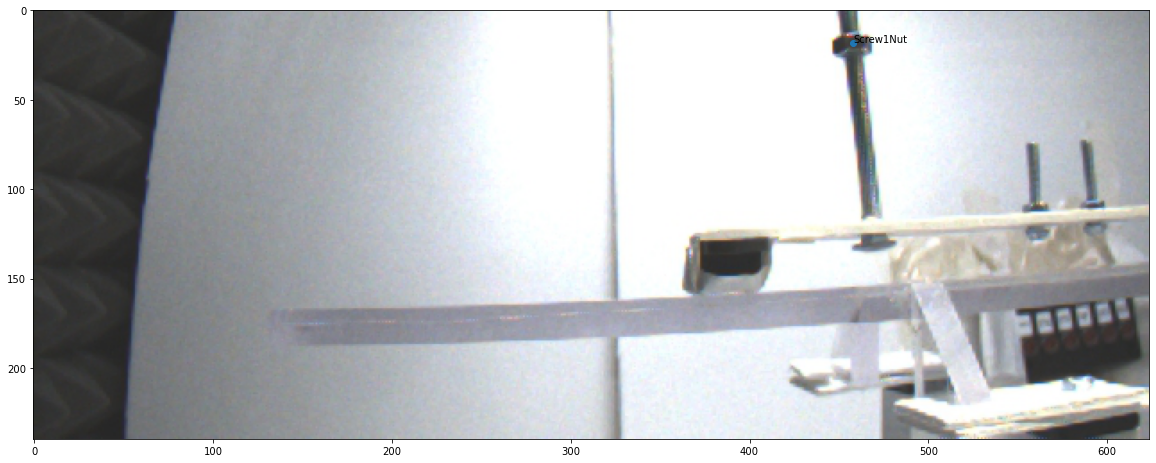

scorer    marker_detection_with_template_matching               
bodyparts                               Screw1Nut               
coords                                          x   y likelihood
0                                             458  18   0.973476


In [55]:
positions_filepath = Path('test_data/positions/220825_Side1_Positions.jpg')
Side1_220826 = TemplateMatching(positions_filepath = positions_filepath, cam_id = "Side1", visualize_matching= True)
Side1_220826.run()
Side1_220826.export_as_DLC_h5()

In [3]:
import numpy as np

In [4]:
a = np.asarray([1, 1, 2, 3, 4, 4])

In [6]:
depth_levels, counts = np.unique(a, return_counts=True)

In [7]:
depth_levels[np.where(counts < 2)] = 0

In [8]:
depth_levels.max()

4

In [5]:
positions_dir = 'test_data/positions/'

In [6]:
Side1_220826 = TemplateMatching(positions_filepath = positions_dir, cam_id = "Side1", visualize_matching= True)
Side1_220826.run()
Side1_220826.export_as_DLC_h5()

NameError: name 'TemplateMatching' is not defined

In [7]:
from skimage.io import imsave

In [8]:
from skimage.feature import match_template

In [9]:
import matplotlib.pyplot as plt
#%matplotlib widget

In [10]:
positions_img = iio.imread('test_data/positions/220824_Side1_Positions.jpg')

In [11]:
template = iio.imread('test_data/templates/Side1_Screw1nut_levelA_template0.jpg')

In [12]:
template_0 = iio.imread('test_data/templates/Side1_Screw1nut_levelA_template0.jpg')
template_1 = iio.imread('test_data/templates/Side1_Screw1nut_levelA_template1.jpg')
template_2 = iio.imread('test_data/templates/Side1_Screw1nut_levelA_template2.jpg')
template_3 = iio.imread('test_data/templates/Side1_Screw1nut_levelA_template4.jpg')


In [31]:
filename = 'Side1_template_Screw1Nut_offset-11-22_lvl-0_000.png'

In [ ]:
MazeCornerOpenLeft
Screw1Nut
LED5


In [32]:
splitted_strings = filename.split('_')

In [35]:
cam_id = splitted_strings[0]
marker_id = splitted_strings[2]
offset_splits = splitted_strings[3].split('-')
offsets = (int(offset_splits[1]), int(offset_splits[2]))
depth_level = int(splitted_strings[4].split('-')[1])
duplicate_id = int(splitted_strings[5][:3])



In [40]:
duplicate_id

0

In [34]:
splitted_strings

['Side1', 'template', 'Screw1Nut', 'offset-11-22', 'lvl-0', '000.png']

for each camera: <br>
&ensp; for each marker: <br>
&ensp;&ensp; for each layer: <br>
&ensp;&ensp;&ensp; - open all templates & determine the marker coords in each <br>
&ensp;&ensp;&ensp; - find minimal column and row indices <br>
&ensp;&ensp;&ensp; - crop all templates, such that these minimal offsets become the common offsets <br>
&ensp;&ensp;&ensp; - save as adjusted templates <br>

In [ ]:
# save offsets to upper left corner in template filename

In [ ]:
input: positionsmarker_coords, marker_id, offsets_to_upper_left_corner, size, cam_id (from positions image filepath?), number_of_levels, zoom_in_step_size

In [13]:
from pathlib import Path
from typing import List, Tuple, Dict, Optional

In [14]:
class CreateNewTemplates:
    
    def __init__(self, image_filepath: Path, cam_id: str) -> None:
        self.image_filepath = image_filepath
        self.cam_id = cam_id
    
    def create_templates_for_marker_id(self, marker_id: str, 
                                       marker_id_coords: Tuple[int, int], 
                                       offsets_to_upper_left_corner: Tuple[int, int] = (25, 25),
                                       template_shape: Tuple[int, int] = (100, 100),
                                       template_level_depth: int = 3,
                                       zoom_factor_per_level: float = 0.25,
                                       save_templates: bool=True,
                                       show_plot: bool=True) -> None:
        depth_level = 0
        image_corner_coords_per_level = []
        base_output_filename = self._get_basis_for_output_filename(marker_id = marker_id)
        upper_left_corner_coords = self._get_upper_left_from_marker_coords(marker_coords = marker_id_coords, 
                                                                         offsets_to_upper_left_corner = offsets_to_upper_left_corner)
        image_corner_coords = self._get_image_corner_coords(upper_left_corner_coords = upper_left_corner_coords, template_shape = template_shape)
        full_output_filename = self._extend_base_output_filename(base_filepath = base_output_filename,
                                                                 offsets_to_upper_left_corner = offsets_to_upper_left_corner,
                                                                 depth_level = depth_level)
        image_corner_coords_per_level.append(image_corner_coords)
        if save_templates:
            self._crop_image_arround_marker_and_save_template_image(output_filepath = full_output_filename, image_corner_coords = image_corner_coords)
        for i in range(template_level_depth - 1):
            depth_level += 1
            offsets_to_upper_left_corner, template_shape = self._update_for_next_depth_level(offsets_to_upper_left_corner = offsets_to_upper_left_corner,
                                                                                             template_shape = template_shape,
                                                                                             zoom_factor_per_level = zoom_factor_per_level)
            upper_left_corner_coor = self._get_upper_left_from_marker_coords(marker_coords = marker_id_coords, 
                                                                             offsets_to_upper_left_corner = offsets_to_upper_left_corner)
            image_corner_coords = self._get_image_corner_coords(upper_left_corner_coords = upper_left_corner_coords, template_shape = template_shape)
            full_output_filename = self._extend_base_output_filename(base_filepath = base_output_filename,
                                                                     offsets_to_upper_left_corner = offsets_to_upper_left_corner,
                                                                     depth_level = depth_level)
            image_corner_coords_per_level.append(image_corner_coords)
            if save_templates:
                self._crop_image_arround_marker_and_save_template_image(output_filepath = full_output_filename, image_corner_coords = image_corner_coords)
        if show_plot:
            self._plot_all_template_levels_on_positions_image(image_corner_coords_per_level = image_corner_coords_per_level)
            
            
    def _get_basis_for_output_filename(self, marker_id: str) -> Path:
        return self.image_filepath.parent.joinpath(f'{self.cam_id}_template_{marker_id}')


    def _get_upper_left_from_marker_coords(self, marker_coords: Tuple[int, int], offsets_to_upper_left_corner: Tuple[int, int]) -> Tuple[int, int]:
        upper_left_row_idx = marker_coords[0] - offsets_to_upper_left_corner[0]
        upper_left_col_idx = marker_coords[1] - offsets_to_upper_left_corner[1]
        return upper_left_row_idx, upper_left_col_idx


    def _get_image_corner_coords(self, upper_left_corner_coords: Tuple[int, int], template_shape: Tuple[int, int]) -> Dict:
        upper_right_coords = (upper_left_corner_coords[0], upper_left_corner_coords[1] + template_shape[1])
        lower_left_coords = (upper_left_corner_coords[0] + template_shape[0], upper_left_corner_coords[1])
        lower_right_coords = (upper_left_corner_coords[0] + template_shape[0], upper_left_corner_coords[1] + template_shape[1])
        all_corner_coords = {'upper_left': upper_left_corner_coords,
                             'upper_right': upper_right_coords,
                             'lower_left': lower_left_coords,
                             'lower_right': lower_right_coords}
        return all_corner_coords
        
        
    def _extend_base_output_filename(self, base_filepath: Path, offsets_to_upper_left_corner: Tuple[int, int], depth_level: int) -> Path:
        marker_id = base_filepath.name[base_filepath.name.find('template_') + 9:]
        templates_already_present = []
        for file in base_filepath.parent.iterdir():
            if (self.cam_id in file.name) and ('template' in file.name) and (marker_id in file.name) in file.name):
                templates_already_present.append(file.name)
        template_idx = str(len(templates_already_present)).zfill(2)
        return self.image_filepath.parent.joinpath(f'{base_filepath.name}_offset-{offsets_to_upper_left_corner[0]}-{offsets_to_upper_left_corner[1]}_lvl-{depth_level}_{template_idx}.png')


    def _crop_image_arround_marker_and_save_template_image(self, output_filepath: Path, image_corner_coords: Dict) -> None:
        image = iio.imread(self.image_filepath)
        row_cropping_idxs = (image_corner_coords['upper_left'][0], image_corner_coords['lower_left'][0])
        column_cropping_idxs = (image_corner_coords['upper_left'][1], image_corner_coords['upper_right'][1])
        template = image[row_cropping_idxs[0] : row_cropping_idxs[1], column_cropping_idxs[0] : column_cropping_idxs[1]].copy()
        imsave(output_filepath, template)


    def _update_for_next_depth_level(self, offsets_to_upper_left_corner: Tuple[int, int], 
                                     template_shape: Tuple[int, int], 
                                     zoom_factor_per_level: float) -> Tuple[Tuple[int, int], Tuple[int, int]]:   
        new_offsets_to_upper_left_corner = tuple([int(coordinate * zoom_factor_per_level) for coordinate in offsets_to_upper_left_corner])
        new_template_shape = tuple([int(n_pixels * zoom_factor_per_level) for n_pixels in template_shape])
        return new_offsets_to_upper_left_corner, new_template_shape


    def _plot_all_template_levels_on_positions_image(self, image_corner_coords_per_level: List[Dict]) -> None:
        #fig = plt.figure(figsize=(15, 10))
        plt.imshow(iio.imread(self.image_filepath))
        for image_corner_coords in image_corner_coords_per_level:
            rows, cols = [], []
            for corner_id in ['upper_left', 'upper_right', 'lower_right', 'lower_left', 'upper_left']:
                rows.append(image_corner_coords[corner_id][0])
                cols.append(image_corner_coords[corner_id][1])
            print(rows, cols)
            plt.plot(cols, rows)
        plt.show()
            
            
            
        
                                       

In [21]:
plt.close()

In [22]:
templates_for_side1 = CreateNewTemplates(image_filepath=Path('test_data/positions/220831_Positions_Side1.jpg'), cam_id = 'Side1')

[46, 46, 146, 146, 46] [336, 486, 486, 336, 336]
[46, 46, 96, 96, 46] [336, 411, 411, 336, 336]
[46, 46, 71, 71, 46] [336, 373, 373, 336, 336]


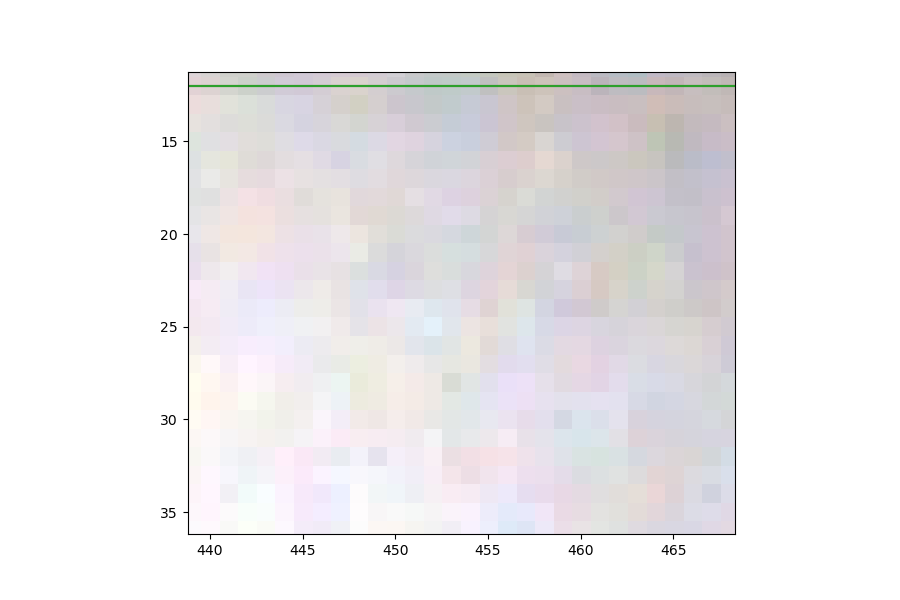

In [23]:
templates_for_side1.create_templates_for_marker_id(marker_id = 'screw1_nut', 
                                                   marker_id_coords=(57, 358), 
                                                   offsets_to_upper_left_corner = (15, 15), 
                                                   template_shape = (100, 150),
                                                   template_level_depth = 3
                                                   zoom_factor_per_level = 0.5,
                                                   save_templates = True,
                                                   show_plot = True)

In [38]:
template_shape: Tuple[int, int] = (100, 100),
                                       template_level_depth: int = 3,
                                       zoom_factor_per_level: float = 0.25,
                                       save_templates: bool=True,
                                       show_plot: bool=True) -> None:

SyntaxError: invalid syntax (<ipython-input-38-435dc6ec13cb>, line 1)

In [16]:
from b06_source.utils import plot_image

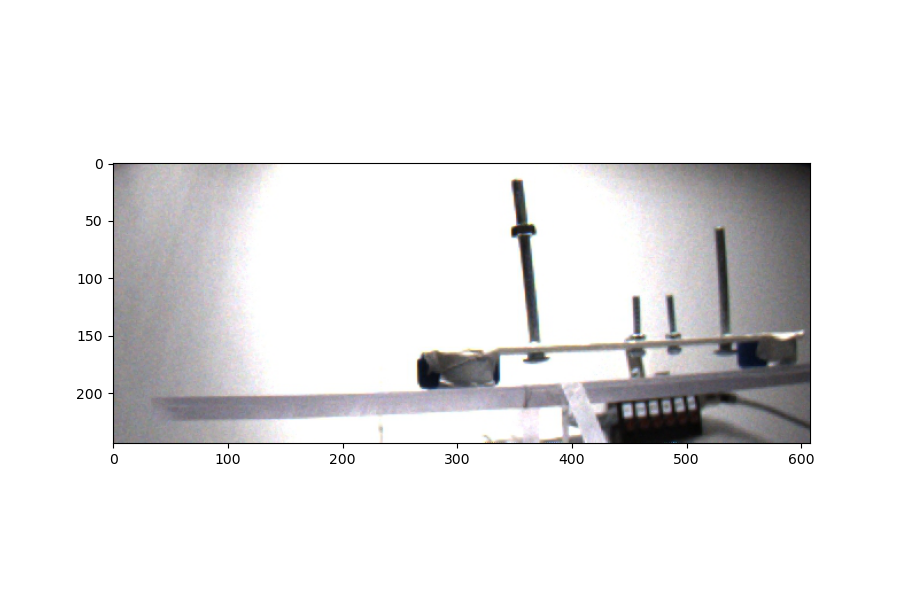

In [20]:
plot_image('test_data/positions/220831_Positions_Side1.jpg')

In [ ]:
row = 57
col = 358

In [15]:
template_0a = template_0[:, 12:].copy()

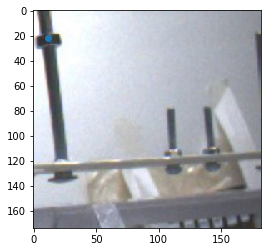

In [16]:
plt.scatter(11, 22)
plt.imshow(template_0a)

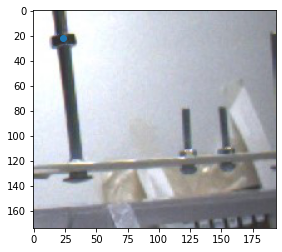

In [17]:
plt.scatter(23, 22)
plt.imshow(template_0)

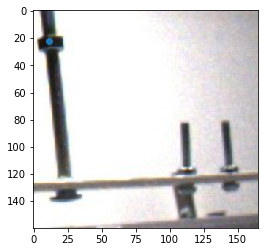

In [18]:
template_1a = template_1[32:, 2:].copy()
plt.scatter(11, 22)
plt.imshow(template_1a)

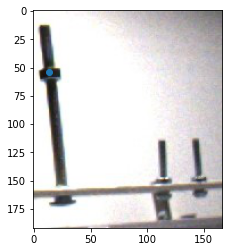

In [19]:
plt.scatter(13, 54)
plt.imshow(template_1)

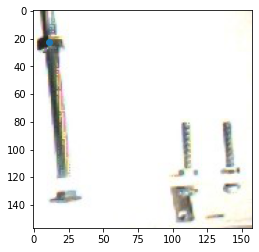

In [20]:
template_2a = template_2[34:, 6:].copy()
plt.scatter(11, 22)
plt.imshow(template_2a)

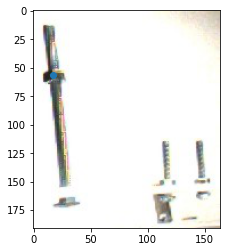

In [21]:
plt.scatter(17, 56)
plt.imshow(template_2)

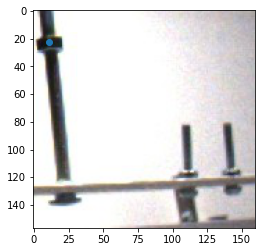

In [22]:
template_3a = template_3[32:, :160].copy()
plt.scatter(11, 22)
plt.imshow(template_3a)

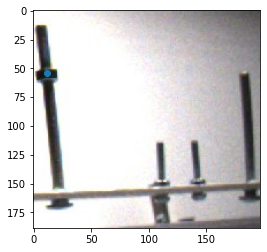

In [23]:
plt.scatter(11, 54)
plt.imshow(template_3)

In [35]:
class AverageMatching:
        
    def get_marker_coordinates(self, subject_image: np.ndarray, template_images: List[np.ndarray]) -> Tuple[int, int]:
        individual_matching_results = self._run_template_matching(subject = subject_image, templates = template_images)
        size_adjusted_results = self._adjust_templates_for_different_sizes(individual_results = individual_matching_results)
        return self._detect_peak_in_average_heatmap(arrays_to_average = size_adjusted_results)
    
    
    def _run_template_matching(self, subject: np.ndarray, templates: List[np.ndarray]) -> List[np.ndarray]:
        heatmap_results = []
        for template_image in templates:
            matching_result = match_template(subject, template_image)
            matching_result[np.where(matching_result < 0)] = 0
            heatmap_results.append(matching_result)
        return heatmap_results
    
    
    def _adjust_templates_for_different_sizes(self, individual_results: List[np.ndarray]) -> List[np.ndarray]:
        max_row_idx = max([array.shape[0] for array in individual_results])
        max_col_idx = max([array.shape[1] for array in individual_results])
        size_adjusted_arrays = []
        for array in individual_results:
            array = array[:, :, 0]
            size_adjusted_arrays.append(np.pad(array, pad_width=((0, max_row_idx - array.shape[0]), (0, max_col_idx - array.shape[1]))))
        return size_adjusted_arrays
    
    
    def _detect_peak_in_average_heatmap(self, arrays_to_average: List[np.ndarray]) -> Tuple[int, int]:
        average_heatmap = np.average(arrays_to_average, axis=0)
        return np.unravel_index(np.argmax(average_heatmap), average_heatmap.shape)

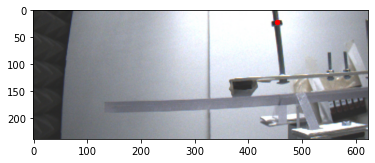

In [51]:
plt.scatter(453, 22, c='red', s=20)
plt.imshow(positions_img)
plt.show()

In [36]:
posi

NameError: name 'posi' is not defined

In [37]:
matching = AverageMatching()
matching.get_marker_coordinates(subject_image = positions_img, template_images = adjusted_templates)

(0, 442)

In [38]:
adjusted_templates = [template_0a, template_1a, template_2a, template_3a]

In [181]:
results = []
for template in adjusted_templates:
    results.append(match_template(positions_img, template))

In [182]:
for array in results:
    array[np.where(array < 0)] = 0

In [183]:
peak_coords = []
for array in results:
    peak_coords.append(np.unravel_index(np.argmax(array), array.shape))

In [184]:
peak_coords

[(0, 442, 0), (0, 441, 0), (0, 442, 0), (0, 442, 0)]

In [185]:
max_row_idx = max([array.shape[0] for array in results])
max_col_idx = max([array.shape[1] for array in results])

In [187]:
size_adjusted_arrays = []
for array in results:
    array = array[:, :, 0]
    size_adjusted_arrays.append(np.pad(array, pad_width=((0, max_row_idx - array.shape[0]), (0, max_col_idx - array.shape[1]))))

In [189]:
mean_heatmap = np.average(size_adjusted_arrays, axis=0)
np.unravel_index(np.argmax(mean_heatmap), mean_heatmap.shape)

(0, 442)

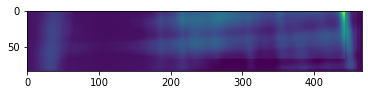

In [190]:
plt.imshow(mean_heatmap)

adjust sizes of templates such that marker coords have always the same row & col offsets from the upper left corner

add averaging to code

done

In [145]:
test = results[0][:, :, 0].copy()

In [146]:
test.shape

(67, 443)

In [148]:
np.pad(test, pad_width=((0,13), (0, 7))).shape

(80, 450)

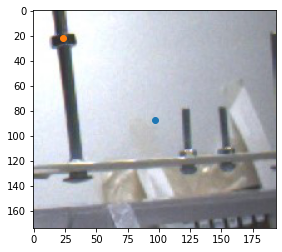

In [65]:
plt.scatter(int(template.shape[1]/2), int(tempalte.shape[0]/2))
plt.scatter(23, 22)
plt.imshow(template)

In [66]:
row_offset = 23 - int(template.shape[1]/2)
col_offset = 22 - int(tempalte.shape[0]/2)

In [67]:
row_offset

-74

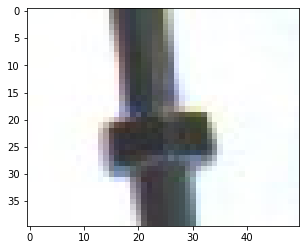

In [23]:
plt.imshow(template[:40, :50])

In [39]:
results = match_template(positions_img, template, pad_input = True, constant_values=0)

In [45]:
positions_gray = rgb2gray(positions_img)
template_gray = rgb2gray(template)
results_gray = match_template(positions_gray, template_gray, pad_input = True)

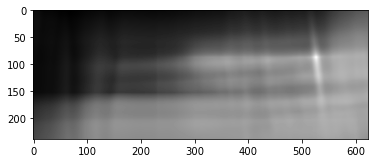

In [82]:
plt.imshow(results_gray, cmap='gray')

In [71]:
np.unravel_index(np.argmax(results, axis=None), results.shape)

(87, 527, 1)

In [79]:
results_thresholded = results.copy()
results_thresholded[np.where(results_thresholded < 0)] = 0

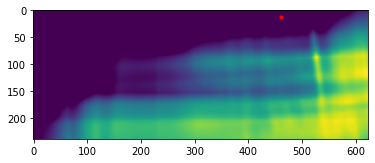

In [90]:
plt.scatter(527+col_offset, 87+row_offset, c='red', s=10)
plt.imshow(results_thresholded[:, :, 0], cmap='viridis')

In [55]:
results_gray.shape

(240, 624)

In [56]:
positions_img.shape

(240, 624, 3)

In [84]:
527 + col_offset

462

In [85]:
87 + row_offset

13

In [86]:
results_no_pad = match_template(positions_img, template)

In [87]:
np.unravel_index(np.argmax(results_no_pad, axis=None), results_no_pad.shape)

(0, 430, 0)

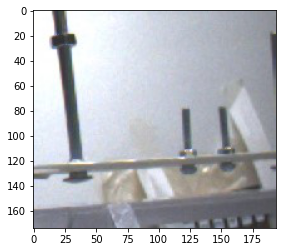

In [93]:
plt.imshow(template)

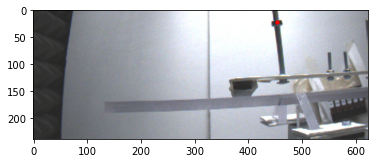

In [91]:
plt.scatter(430+23, 0+22, c='red', s=10)
plt.imshow(positions_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


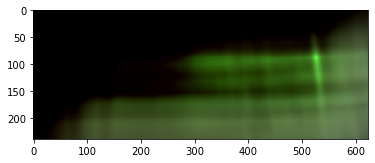

In [41]:
plt.imshow(results)

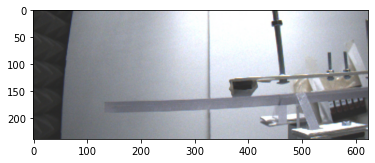

In [21]:
plt.imshow(positions_img)

In [5]:
positions_dir = '/mnt/c/Users/dsege'

Now analyzing Bottom!


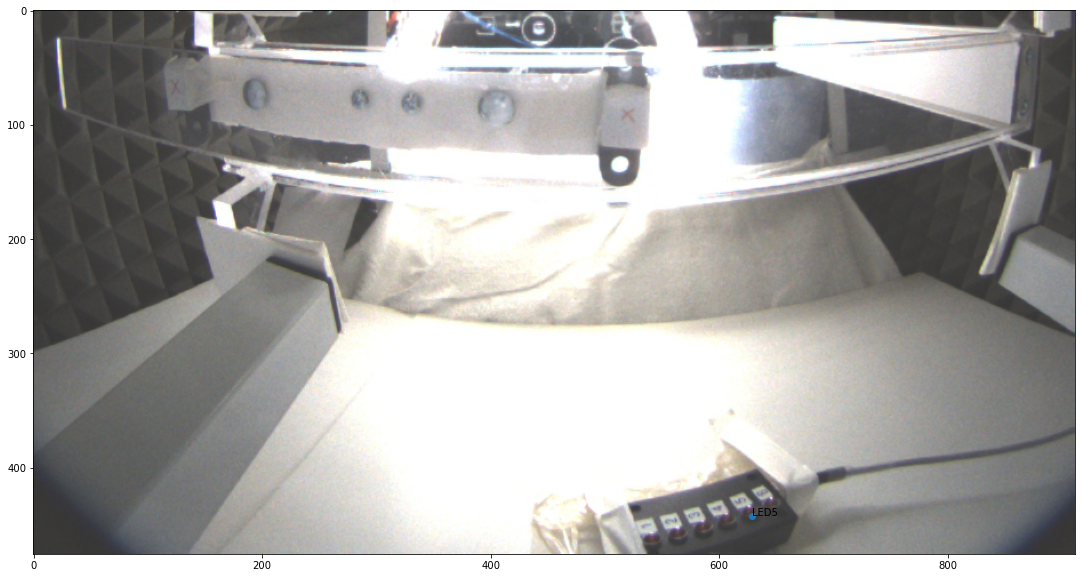

scorer    templatematched_marker_positions                
bodyparts                             LED5                
coords                                   x    y likelihood
0                                      629  442   0.881722


In [7]:
Bottom_220826 = TemplateMatching(positions_filepath = positions_dir, cam_id = "Bottom", visualize_matching= True)
Bottom_220826.run()
Bottom_220826.export_as_DLC_h5()

